# MonthlyIncome は数値変換を行い、正規分布に近づける

## 学習用データセットの、ランダムな連続の欠損値は削除済み

In [1]:
import os
os.chdir('../../')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scr.util import *

In [3]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.pipeline import Pipeline

In [4]:
df_train = pd.read_csv('data/null_survey/train_age_ok.csv')
df_test = pd.read_csv('data/null_survey/test_age_ok.csv')

In [6]:
df_train.isna().sum()

id                        0
Age                       0
TypeofContact             0
CityTier                  0
DurationOfPitch           0
Occupation                0
Gender                    0
NumberOfPersonVisiting    0
NumberOfFollowups         0
ProductPitched            0
PreferredPropertyStar     0
NumberOfTrips             0
Passport                  0
PitchSatisfactionScore    0
Designation               0
MonthlyIncome             0
ProdTaken                 0
Marry                     0
Car                       0
Child                     0
AgeGroup                  0
dtype: int64

In [7]:
df_test.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch           131
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              42
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome              49
Marry                       0
Car                         0
Child                       0
AgeGroup                    0
dtype: int64

In [8]:
# MonthlyIncome を正規分布に近づける
df_train['MonthlyIncome'] = np.log1p(df_train['MonthlyIncome'])
df_test['MonthlyIncome'] = np.log1p(df_test['MonthlyIncome'])

In [9]:
df_train['MonthlyIncome'].isna().sum()

0

In [10]:
df_test['MonthlyIncome'].isna().sum()

49

In [11]:
df_train['MonthlyIncome']

0       12.444719
1       12.910348
2       12.697122
3       12.462403
4       12.468441
          ...    
3232    12.464201
3233    12.470036
3234    12.667732
3235    13.176683
3236    12.536063
Name: MonthlyIncome, Length: 3237, dtype: float64

In [12]:
df_test['MonthlyIncome']

0       13.116247
1       12.611541
2       12.468441
3       12.467960
4       12.501838
          ...    
3484    12.475493
3485    12.765034
3486    12.506181
3487    12.515141
3488    12.928283
Name: MonthlyIncome, Length: 3489, dtype: float64

# 今回調査する欠損値：Age, DurationOfPitch, NumberOfTrips, *MonthlyIncome*

# MonthlyIncome

In [13]:
df_all = pd.concat([df_train, df_test], axis=0)

In [14]:
# MonthlyIncomeを予測するための特徴量を選択
predict_income_features = ['Age', 'TypeofContact','CityTier','Occupation','Gender','NumberOfPersonVisiting',
                        'NumberOfFollowups','ProductPitched','PreferredPropertyStar','PitchSatisfactionScore', 'Passport','Designation' ,'Marry', 'Car','Child', 'AgeGroup']

# 主キー用idを取得
# id_train = df_train.loc[df_train['MonthlyIncome'].isna()].index
id_test = df_test.loc[df_test['MonthlyIncome'].isna(), 'id'].values

# 目的変数をMonthlyIncomeとする
X_train_predict_income = df_all.loc[~(df_all['MonthlyIncome'].isna()), predict_income_features]
X_test_predict_income = df_all.loc[df_all['MonthlyIncome'].isna(), predict_income_features]
y_train_predict_income = df_all.loc[~(df_all['MonthlyIncome'].isna()), 'MonthlyIncome']
y_test_predict_income = None

<Axes: >

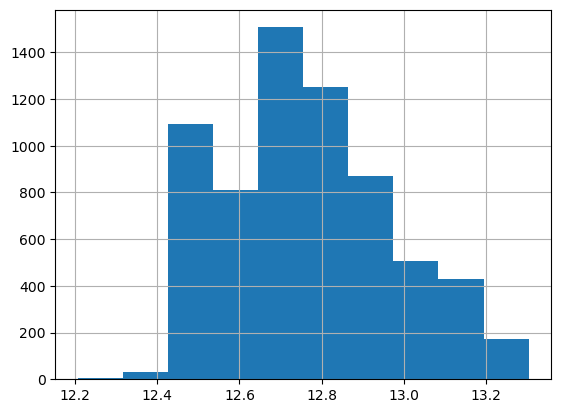

In [17]:
y_train_predict_income.hist()

In [19]:
X_train_predict_income = mapping_columns_if_exist(X_train_predict_income)
X_test_predict_income = mapping_columns_if_exist(X_test_predict_income)

In [20]:
X_train_predict_income, X_test_predict_income = feature_to_int(X_train_predict_income, X_test_predict_income)

In [24]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_list = list(kf.split(X_train_predict_income, y_train_predict_income))

def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        model = cb.CatBoostRegressor(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict(va_x)
        models.append(model)
    return oof_pred, models

params = {
    'loss_function': 'Quantile:alpha=0.5',
    'eval_metric': 'Quantile:alpha=0.5',
    'iterations': 7000,
    'learning_rate': 0.005,
    'depth': 5,
    'l2_leaf_reg': 3,    # 3 ~ 10
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(X_train_predict_income, y_train_predict_income, cv_list, params)

0:	learn: 0.0814737	test: 0.0833884	best: 0.0833884 (0)	total: 1.66ms	remaining: 11.6s
100:	learn: 0.0636209	test: 0.0649638	best: 0.0649638 (100)	total: 136ms	remaining: 9.29s
200:	learn: 0.0540161	test: 0.0552473	best: 0.0552473 (200)	total: 270ms	remaining: 9.12s
300:	learn: 0.0495514	test: 0.0506312	best: 0.0506312 (300)	total: 399ms	remaining: 8.88s
400:	learn: 0.0473600	test: 0.0482782	best: 0.0482782 (400)	total: 543ms	remaining: 8.94s
500:	learn: 0.0461390	test: 0.0470288	best: 0.0470288 (500)	total: 677ms	remaining: 8.78s
600:	learn: 0.0453063	test: 0.0462638	best: 0.0462638 (600)	total: 815ms	remaining: 8.68s
700:	learn: 0.0447729	test: 0.0458139	best: 0.0458139 (700)	total: 951ms	remaining: 8.55s
800:	learn: 0.0443871	test: 0.0455171	best: 0.0455171 (800)	total: 1.08s	remaining: 8.4s
900:	learn: 0.0440906	test: 0.0452927	best: 0.0452927 (900)	total: 1.21s	remaining: 8.22s
1000:	learn: 0.0438658	test: 0.0451545	best: 0.0451545 (1000)	total: 1.34s	remaining: 8.06s
1100:	learn:

In [25]:
y_test_predict_income = np.zeros(len(X_test_predict_income))

# アンサンブル
for model in models:
    y_test_predict_income += model.predict(X_test_predict_income) / len(models)

# y_test_predict_income = pd.DataFrame({
#     'MonthlyIncome': y_test_predict_income
# })

In [95]:
# # 訓練データとテストデータに分割する
# predicted_train_income = y_test_predict_income.iloc[:len(id_train), 0]
# predicted_test_income = y_test_predict_income.iloc[len(id_train): , 0]

# # id(主キー)を与える。
# predicted_train_income.index = id_train
# predicted_test_income.index = id_test

In [29]:
df_test[2155:2160]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Marry,Car,Child,AgeGroup
2155,5644,30,Self Enquiry,2,420.0,Large Business,male,3.0,4.0,Standard,3.0,12.0,0,4,Senior Manager,12.777013,Divorced,Has Car,1_child,30s
2156,5645,25,Self Enquiry,2,900.0,Salaried,male,3.0,4.0,Basic,3.0,3.0,0,4,Executive,12.650858,Single,Has Car,2_child,20s
2157,5646,29,Company Invited,2,1020.0,Small Business,male,2.0,3.0,Basic,3.0,8.0,0,4,Executive,NaN,Single,No Car,1_child,20s
2158,5647,34,Self Enquiry,1,540.0,Small Business,male,3.0,4.0,Basic,3.0,2.0,0,4,Executive,NaN,Married,Has Car,1_child,30s
2159,5648,24,Self Enquiry,1,480.0,Small Business,female,4.0,5.0,Deluxe,4.0,3.0,0,1,Executive,12.823987,Married,No Car,2_child,20s


In [36]:
for index, value in zip(id_test, y_test_predict_income):
    df_test.loc[df_test['id'] == index, 'MonthlyIncome'] = value

In [98]:
# # 欠損値を予測値で補完する
# df_train.loc[df_train['MonthlyIncome'].isna(), 'MonthlyIncome'] = round(predicted_train_income)
# df_test.loc[df_test['MonthlyIncome'].isna(), 'MonthlyIncome'] = round(predicted_test_income)

In [37]:
df_test[2155:2160]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Marry,Car,Child,AgeGroup
2155,5644,30,Self Enquiry,2,420.0,Large Business,male,3.0,4.0,Standard,3.0,12.0,0,4,Senior Manager,12.777013,Divorced,Has Car,1_child,30s
2156,5645,25,Self Enquiry,2,900.0,Salaried,male,3.0,4.0,Basic,3.0,3.0,0,4,Executive,12.650858,Single,Has Car,2_child,20s
2157,5646,29,Company Invited,2,1020.0,Small Business,male,2.0,3.0,Basic,3.0,8.0,0,4,Executive,12.500176,Single,No Car,1_child,20s
2158,5647,34,Self Enquiry,1,540.0,Small Business,male,3.0,4.0,Basic,3.0,2.0,0,4,Executive,12.652087,Married,Has Car,1_child,30s
2159,5648,24,Self Enquiry,1,480.0,Small Business,female,4.0,5.0,Deluxe,4.0,3.0,0,1,Executive,12.823987,Married,No Car,2_child,20s


In [38]:
df_train.isna().sum()

id                        0
Age                       0
TypeofContact             0
CityTier                  0
DurationOfPitch           0
Occupation                0
Gender                    0
NumberOfPersonVisiting    0
NumberOfFollowups         0
ProductPitched            0
PreferredPropertyStar     0
NumberOfTrips             0
Passport                  0
PitchSatisfactionScore    0
Designation               0
MonthlyIncome             0
ProdTaken                 0
Marry                     0
Car                       0
Child                     0
AgeGroup                  0
dtype: int64

In [39]:
df_test.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch           131
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              42
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome               0
Marry                       0
Car                         0
Child                       0
AgeGroup                    0
dtype: int64

In [40]:
df_train.to_csv('data/null_survey/train_age_income_ok.csv', index=False)
df_test.to_csv('data/null_survey/test_age_income_ok.csv', index=False)